In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prim
import seaborn as sns
from sklearn import mixture
import os
from clustering_and_prim_tools import *
from pandas_helper import *

In [2]:
%matplotlib inline

In [3]:
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

In [4]:
datafolder = "C:\\Users\\WB451855\\OneDrive - WBG\\!infra_needs_data\\transport_itf_output_data\\"
datafoldercity = "C:\\Users\\WB451855\\OneDrive - WBG\\!infra_needs_data\\transport_itf_output_data\\per city\\"
datafolderold = "C:\\Users\\WB451855\\OneDrive - WBG\\!infra_needs_data\\transport_itf_output_data\\old\\"

In [5]:
os.listdir(datafolder)

['country_data.csv',
 'Demand.csv',
 'GCAP.csv',
 'GDP.csv',
 'MetaData.docx',
 'old',
 'per city',
 'PT_infra.csv',
 'Road_infra.csv',
 'ScenarioVariable.csv',
 'wbccodes2014.csv']

In [6]:
os.listdir(datafoldercity)

['country_data.csv',
 'MetaData.docx',
 'PT_infra.csv',
 'PT_infra_city.csv',
 'Road_infra.csv',
 'Road_infra_city.csv',
 'ScenarioVariable.csv',
 'ScenarioVariable_city.csv']

# Load data

In [7]:
pt_infra_c = pd.read_csv(datafoldercity+"PT_infra_city.csv",encoding='latin-1')
road_infra_c = pd.read_csv(datafoldercity+"Road_infra_city.csv",encoding='latin-1')
scenario_c = pd.read_csv(datafoldercity+"ScenarioVariable_city.csv",encoding='latin-1')

In [8]:
demand = pd.read_csv(datafolder+"Demand.csv")
gcap_pop = pd.read_csv(datafolder+"GCAP.csv")
gdp = pd.read_csv(datafolder+"GDP.csv")

pt_infra = pd.read_csv(datafolder+"PT_infra.csv",encoding='latin-1')
#pt_infra = pd.read_csv(datafolderold+"PT_infra.csv",encoding='latin-1')

road_infra = pd.read_csv(datafolder+"Road_infra.csv",encoding='latin-1')
scenario = pd.read_csv(datafolder+"ScenarioVariable.csv",encoding='latin-1')

In [9]:
country_data = pd.read_csv(datafolder+"country_data.csv",encoding='latin-1')

In [10]:
pt_infra.columns

Index(['ISO3', 'SC', 'Year', 'infraPt', 'capitalCostBus', 'busVKM', 'ptVKM',
       'busEmiss', 'lighRail_BRTLength', 'undergroundRailLength', 'OM_infraPt',
       'OM_vehiclePt'],
      dtype='object')

In [11]:
country_data.columns

Index(['ISO3', 'Year', 'GDP_USD2010', 'GCAP_USD2010', 'CarOwn'], dtype='object')

In [12]:
scenario_c.columns

Index(['city_ID', 'SC', 'Year', 'ISO3', 'Income.group', 'POP', 'GCAP',
       'carPKM', 'motorPKM', 'ptPKM', 'walkPKM', 'cyclePKM', 'totTrip',
       'Density', 'city_name'],
      dtype='object')

In [13]:
scenario_c.set_index(["ISO3","SC","Year","city_ID"]).totTrip.sum(level=["SC"])

SC
BAU    2.294875e+13
LUT    2.294336e+13
ROG    2.294549e+13
Name: totTrip, dtype: float64

## merge data

In [14]:
all_c = scenario_c.merge(pt_infra_c,on=["ISO3","SC","Year","city_ID"]).merge(road_infra_c,on=["ISO3","SC","Year","city_ID"])

In [15]:
all_c["total_inv"] = all_c.infraPt+all_c.localroad_invest_billion+all_c.mainroad_invest_billion
all_c["GDP"] = all_c.GCAP*all_c.POP*1000
all_c["total_inv_over_gdp"] = 10**9*all_c.total_inv/all_c.GDP

In [16]:
new_index = pd.Index(np.arange(2010,2051))
new_index.name = "Year_all"

In [17]:
test = country_data.set_index(["ISO3"])

## interpolate GDP between the 5 years periods

In [18]:
newdata = test.loc[test.GDP_USD2010!="null",:].copy()
newdata.loc[:,"GDP_USD2010"] = newdata.GDP_USD2010.astype(float)
just_index = broadcast_simple(newdata["GDP_USD2010"].mean(level="ISO3"),new_index).reset_index().drop("GDP_USD2010",axis=1)

In [19]:
to_interp = just_index.rename(columns={"Year_all":"Year"}).merge(newdata.reset_index(),on=["ISO3","Year"],how='outer')

In [20]:
new_data = to_interp.set_index(["ISO3","Year"]).interpolate()

In [21]:
new_data["GDP_USD2010"];

In [22]:
def f(x):
    x = x.reset_index()
    y = pd.DataFrame(columns=["Year","GDP_country_interp"])
    for year in [2015,2020,2025,2030,2035,2040,2045,2050]:
        y = y.append(pd.DataFrame([[round(year),x.loc[(x.Year<=year)&(x.Year>year-5),"GDP_USD2010"].sum()]],columns=["Year","GDP_country_interp"]),ignore_index=True)
    return y

In [23]:
new_gdp = new_data.groupby(level=["ISO3"]).apply(f)

In [24]:
new_gdp.reset_index().drop("level_1",axis=1).sample(3)

,ISO3,Year,GDP_country_interp
1249,SRB,2020,4.045042e+11
75,AUT,2030,2.054961e+12
1083,PER,2030,3.443700e+12


In [25]:
pt_infra.columns

Index(['ISO3', 'SC', 'Year', 'infraPt', 'capitalCostBus', 'busVKM', 'ptVKM',
       'busEmiss', 'lighRail_BRTLength', 'undergroundRailLength', 'OM_infraPt',
       'OM_vehiclePt'],
      dtype='object')

In [26]:
all_v = scenario.merge(pt_infra,on=["ISO3","SC","Year"]).merge(road_infra,on=["ISO3","SC","Year"]).merge(new_gdp.reset_index().drop("level_1",axis=1),on=["ISO3","Year"])

In [27]:
codes = pd.read_csv(datafolder+"wbccodes2014.csv")

In [28]:
all_c = all_c.reset_index().merge(codes.rename(columns={"country":"ISO3"}),on="ISO3",how="left")

In [29]:
all_v = all_v.reset_index().merge(codes.rename(columns={"country":"ISO3"}),on="ISO3",how="left")

In [30]:
all_v.columns

Index(['index', 'SC', 'Year', 'ISO3', 'Income.group', 'POP', 'GCAP', 'carPKM',
       'motorPKM', 'ptPKM', 'walkPKM', 'cyclePKM', 'totTrip', 'Density',
       'infraPt', 'capitalCostBus', 'busVKM', 'ptVKM', 'busEmiss',
       'lighRail_BRTLength', 'undergroundRailLength', 'OM_infraPt',
       'OM_vehiclePt', 'localroad_invest_billion', 'mainroad_invest_billion',
       'main_road', 'car_usage', 'car_capital_cost', 'carEmiss', 'local_rd',
       'road_OM_extra', 'road_OM_2015', 'CarVKM', 'GDP_country_interp',
       'country_name', 'wbregion', 'wbregionname', 'wbincome', 'wbincomename',
       'wblending', 'wbhipc'],
      dtype='object')

In [31]:
all_v.wbincome.unique()

array(['HIO', 'HIX', 'UMI', 'LMI', 'LIC'], dtype=object)

In [32]:
all_v = all_v.loc[all_v.Year<2035,:]

In [33]:
all_v = all_v.set_index(["ISO3","SC","Year","wbregion"])

In [34]:
all_v["total_inv"] = all_v.infraPt+all_v.capitalCostBus+all_v.localroad_invest_billion+all_v.mainroad_invest_billion
all_v["GDP_city"] = all_v.GCAP*all_v.POP*1000
all_v["total_inv_over_gdp_city"] = 10**9*all_v.total_inv/all_v.GDP_city
all_v["total_inv_over_gdp_country"] = 10**9*all_v.total_inv/all_v.GDP_country_interp

all_v["maintenance_over_gdp_country"] = 10**9*(all_v.road_OM_extra+all_v.road_OM_2015+all_v.OM_infraPt+all_v.OM_vehiclePt)/all_v.GDP_country_interp

all_v["public_transport_investments"] = all_v.infraPt+all_v.capitalCostBus
all_v["road_investments"] = all_v.localroad_invest_billion+all_v.mainroad_invest_billion
all_v["roads_maintenance"] = all_v.road_OM_extra+all_v.road_OM_2015

all_v["total_total"] = all_v["total_inv"]+all_v["roads_maintenance"]+all_v.OM_infraPt+all_v.OM_vehiclePt

all_v["total_maintenance"] = all_v["roads_maintenance"]+all_v.OM_infraPt+all_v.OM_vehiclePt

## discounts data

In [35]:
all_v = all_v.reset_index().set_index(["SC"])

In [36]:
def discount_sum_over_5_years(row,name,d):
    return np.sum([row[name]/5*(1+d)**(1-(year-2015)) for year in np.arange(row["Year"]-4,row["Year"]+1)])

In [37]:
all_v["public_transport_investments_disc"] = all_v.apply(lambda y:discount_sum_over_5_years(y,"public_transport_investments",0.06),axis=1)
all_v["road_investments_disc"] = all_v.apply(lambda y:discount_sum_over_5_years(y,"road_investments",0.06),axis=1)
all_v["roads_maintenance_disc"] = all_v.apply(lambda y:discount_sum_over_5_years(y,"roads_maintenance",0.06),axis=1)
all_v["pt_maintenance"] = all_v.apply(lambda y:discount_sum_over_5_years(y,"OM_infraPt",0.06),axis=1)
all_v["pt_operation"] = all_v.apply(lambda y:discount_sum_over_5_years(y,"OM_vehiclePt",0.06),axis=1)
all_v["total_inv_disc"] = all_v.apply(lambda y:discount_sum_over_5_years(y,"total_inv",0.06),axis=1)
all_v["total_total_disc"] = all_v.apply(lambda y:discount_sum_over_5_years(y,"total_total",0.06),axis=1)
all_v["total_maintenance_disc"] = all_v.apply(lambda y:discount_sum_over_5_years(y,"total_maintenance",0.06),axis=1)

In [38]:
all_v = all_v.reset_index().set_index(["ISO3","SC","Year"])

### chiffre: annual capital needs

In [39]:
1/15*all_v.total_inv_disc.sum(level="SC")

SC
BAU    495.864694
LUT    433.795914
ROG    523.672518
Name: total_inv_disc, dtype: float64

In [48]:
1/15*all_v[["roads_maintenance_disc","pt_maintenance"]].sum(level="SC").sum(axis=1)

SC
BAU    336.531968
LUT    323.985437
ROG    330.908513
dtype: float64

In [49]:
1/15*all_v[["pt_operation"]].sum(level="SC")

,pt_operation
SC,
BAU,975.239942
LUT,1291.606071
ROG,1295.184665


In [40]:
all_v_s = all_v.sum(level=["SC","Year"])
all_v_s["total_inv_over_gdp_country"] = 10**9*all_v_s.total_inv/all_v_s.GDP_country_interp
all_v_s["maintenance_over_gdp_country"] = 10**9*(all_v_s.road_OM_extra+all_v_s.road_OM_2015+all_v_s.OM_infraPt+all_v_s.OM_vehiclePt)/all_v_s.GDP_country_interp
all_v_s["total_total_gdp_country"] = 10**9*all_v_s.total_total/all_v_s.GDP_country_interp

In [41]:
100*all_v_s.maintenance_over_gdp_country.mean(level="SC")

SC
BAU    1.253474
LUT    1.575482
ROG    1.587235
Name: maintenance_over_gdp_country, dtype: float64

### developing countries only

In [42]:
all_v_s_dev = all_v.reset_index().loc[all_v.reset_index().wbregion!='YHI',:].set_index(["ISO3","SC","Year","wbregion"]).sum(level=["SC","Year"])
all_v_s_dev["total_inv_over_gdp_country"] = 10**9*all_v_s_dev.total_inv/all_v_s_dev.GDP_country_interp
all_v_s_dev["OandM_over_gdp_country"] = 10**9*(all_v_s_dev.road_OM_extra+all_v_s_dev.road_OM_2015+all_v_s_dev.OM_infraPt+all_v_s_dev.OM_vehiclePt)/all_v_s_dev.GDP_country_interp
all_v_s_dev["total_total_gdp_country"] = 10**9*all_v_s_dev.total_total/all_v_s_dev.GDP_country_interp
all_v_s_dev["maintenance_over_gdp_country"] = 10**9*(all_v_s_dev.road_OM_extra+all_v_s_dev.road_OM_2015+all_v_s_dev.OM_infraPt)/all_v_s_dev.GDP_country_interp
all_v_s_dev["operations_over_gdp_country"] = 10**9*(all_v_s_dev.OM_vehiclePt)/all_v_s_dev.GDP_country_interp

In [50]:
1/15*all_v_s_dev.total_inv_disc.sum(level="SC")

SC
BAU    237.138156
LUT    194.655279
ROG    244.882904
Name: total_inv_disc, dtype: float64

In [51]:
1/15*all_v_s_dev[["roads_maintenance_disc","pt_maintenance"]].sum(level="SC").sum(axis=1)

SC
BAU    108.876971
LUT    102.105100
ROG    106.429296
dtype: float64

In [52]:
1/15*all_v_s_dev[["pt_operation"]].sum(level="SC")

,pt_operation
SC,
BAU,518.985992
LUT,659.680049
ROG,665.929546


In [54]:
100*all_v_s_dev.operations_over_gdp_country.mean(level="SC")

SC
BAU    0.992870
LUT    1.268546
ROG    1.280880
Name: operations_over_gdp_country, dtype: float64

In [55]:
100*all_v_s_dev.maintenance_over_gdp_country.mean(level="SC")

SC
BAU    0.208516
LUT    0.195302
ROG    0.203835
Name: maintenance_over_gdp_country, dtype: float64

In [56]:
100*all_v_s_dev.total_inv_over_gdp_country.mean(level="SC")

SC
BAU    0.454236
LUT    0.371363
ROG    0.469477
Name: total_inv_over_gdp_country, dtype: float64

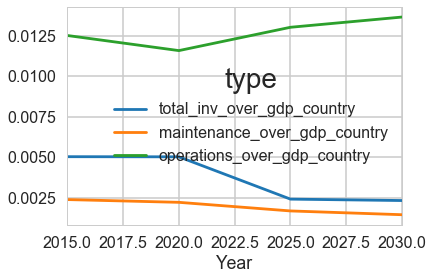

In [62]:
best_scenario = all_v_s_dev[["total_inv_over_gdp_country","maintenance_over_gdp_country","operations_over_gdp_country"]].copy()
best_scenario.columns.name="type"
best_scenario.stack().unstack("SC")["LUT"].unstack("type").plot()

In [48]:
all_v = all_v.reset_index().set_index(["ISO3","SC","Year","wbregion"])

In [49]:
all_v["total_total_disc"].sum(level="SC")/all_v["total_total_disc"].sum(level="SC")["BAU"]

SC
BAU    1.000000
LUT    1.133739
ROG    1.189269
Name: total_total_disc, dtype: float64

### by region

In [53]:
all_v_r_s = all_v.sum(level=["SC","Year","wbregion"])
all_v_r_s["total_total_gdp_country"] = 10**9*all_v_r_s.total_total/all_v_r_s.GDP_country_interp
all_v_r_s["total_inv_over_gdp_country"] = 10**9*all_v_r_s.total_inv/all_v_r_s.GDP_country_interp
all_v_r_s["total_maint_over_gdp_country"] = 10**9*(all_v_r_s.road_OM_extra+all_v_r_s.road_OM_2015+all_v_r_s.OM_infraPt+all_v_r_s.OM_vehiclePt)/all_v_r_s.GDP_country_interp
all_v_r_s["total_road_maint_over_gdp_country"] = 10**9*(all_v_r_s.road_OM_extra+all_v_r_s.road_OM_2015)/all_v_r_s.GDP_country_interp
all_v_r_s["total_pt_maint_over_gdp_country"] = 10**9*(all_v_r_s.OM_infraPt)/all_v_r_s.GDP_country_interp
all_v_r_s["total_pt_ope_over_gdp_country"] = 10**9*(all_v_r_s.OM_vehiclePt)/all_v_r_s.GDP_country_interp

In [54]:
all_v_ir_s = all_v.reset_index().set_index(["ISO3","SC","Year","wbincomename"]).sum(level=["SC","Year","wbincomename"])
all_v_ir_s["total_total_gdp_country"] = 10**9*all_v_ir_s.total_total/all_v_ir_s.GDP_country_interp

### chiffre: total inv by region

In [63]:
1/15*all_v_r_s.total_inv_disc.sum(level=["wbregion","SC"])

wbregion  SC 
EAP       BAU     99.714101
          LUT     90.229398
          ROG    104.810058
ECA       BAU     22.264607
          LUT     16.815014
          ROG     22.238520
LAC       BAU     53.429895
          LUT     40.732863
          ROG     54.588194
MNA       BAU     21.228437
          LUT     15.251147
          ROG     20.988482
SAS       BAU     25.985218
          LUT     20.797039
          ROG     27.408071
SSA       BAU     14.515898
          LUT     10.829817
          ROG     14.849580
YHI       BAU    258.726538
          LUT    239.140635
          ROG    278.789614
Name: total_inv_disc, dtype: float64

In [55]:
100*all_v_r_s.total_inv_over_gdp_country.mean(level=["wbregion"])

wbregion
EAP    0.400267
ECA    0.530189
LAC    0.588598
MNA    0.568106
SAS    0.278999
SSA    0.435081
YHI    0.496040
Name: total_inv_over_gdp_country, dtype: float64

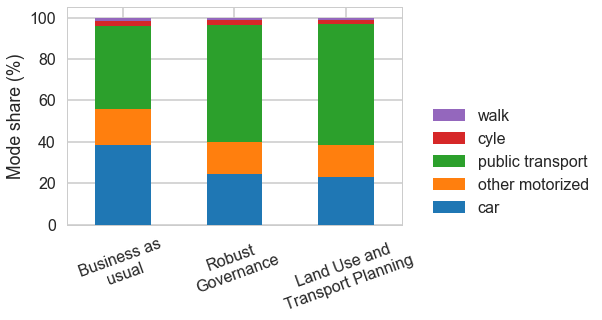

In [72]:
to_plot = (all_v_s_dev.reset_index().loc[all_v_s_dev.reset_index().Year==2030,["carPKM","motorPKM","ptPKM","cyclePKM","walkPKM","SC"]].set_index("SC"))
to_plot['total'] = to_plot.sum(axis=1)
to_plot = 100*to_plot.div(to_plot['total'],axis=0).drop("total",axis=1)
to_plot = to_plot.reset_index()

to_plot["SC"] = to_plot.SC.replace({"BAU":"0BAU","LUT":"2LUT","ROG":"1ROG"})
to_plot = to_plot.set_index("SC").sort_index(level="SC")
to_plot = to_plot.reset_index()

to_plot["SC"] = to_plot.SC.replace({"0BAU":"Business as\nusual","2LUT":"Land Use and\nTransport Planning","1ROG":"Robust\nGovernance"})

fig, ax1 = plt.subplots()
to_plot.set_index("SC")[["carPKM","motorPKM","ptPKM","cyclePKM","walkPKM"]].rename(columns={"carPKM":"car","motorPKM":"other motorized",\
                                                                                    "ptPKM":"public transport","cyclePKM":"cyle","walkPKM":"walk"}).plot(kind="bar",stacked=True,ax=ax1)
plt.xticks(rotation=20)
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,3,2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],bbox_to_anchor=(1.05, 0.6))
plt.xlabel("")
plt.ylabel("Mode share (%)")


#ax2 = ax1.twinx()
#to_plot.set_index("SC")["Access gain"].plot(kind="line",ax=ax2)
#ax2.grid(b=None)
#ax2.set_ylabel("Access gain")

plt.savefig("ITF_total_pkm_2030_pc_dev.png",ddpi=300,bbox_inches="tight")
plt.savefig("ITF_total_pkm_2030_pc_dev.pdf")

In [57]:
100*all_v_r_s[["total_road_maint_over_gdp_country","total_pt_maint_over_gdp_country"]].sum(axis=1).mean(level=["wbregion"])

wbregion
EAP    0.153279
ECA    0.347247
LAC    0.421917
MNA    0.248722
SAS    0.074200
SSA    0.137313
YHI    0.431601
dtype: float64

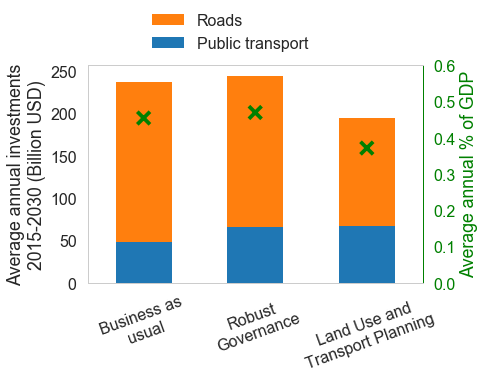

In [50]:
to_plot = all_v_s_dev.reset_index().set_index(["SC","Year"])[["pt_maintenance","roads_maintenance_disc","public_transport_investments_disc","road_investments_disc"]].sum(level="SC")
to_plot = to_plot.reset_index()

to_plot2 = all_v_s_dev.reset_index().set_index(["SC","Year"])[["total_inv_over_gdp_country","maintenance_over_gdp_country"]].mean(level="SC")
to_plot2 = to_plot2.reset_index()

to_plot["SC"] = to_plot.SC.replace({"BAU":"0BAU","LUT":"2LUT","ROG":"1ROG"})
to_plot = to_plot.set_index("SC").sort_index(level="SC")
to_plot = to_plot.reset_index()

to_plot2["SC"] = to_plot2.SC.replace({"BAU":"0BAU","LUT":"2LUT","ROG":"1ROG"})
to_plot2 = to_plot2.set_index("SC").sort_index(level="SC")
to_plot2 = to_plot2.reset_index()

to_plot["SC"] = to_plot.SC.replace({"0BAU":"Business as\nusual","2LUT":"Land Use and\nTransport Planning","1ROG":"Robust\nGovernance"})
to_plot2["SC"] = to_plot2.SC.replace({"0BAU":"Business as\nusual","2LUT":"Land Use and\nTransport Planning","1ROG":"Robust\nGovernance"})

to_plot["public_transport_investments_disc"] = 1/15*to_plot.public_transport_investments_disc
to_plot["road_investments_disc"] = 1/15*to_plot.road_investments_disc

fig, ax2 = plt.subplots()
#fig.set_size_inches(15, 5)

to_plot.set_index("SC")[["public_transport_investments_disc","road_investments_disc"]].rename(columns={"public_transport_investments_disc":"Public transport",\
                                                                                                       "road_investments_disc":"Roads"}).plot(kind="bar",stacked=True,ax=ax2)
plt.xticks(rotation=20)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],bbox_to_anchor=(0.15, 1.))
plt.xlabel("")
plt.ylabel("Average annual investments\n2015-2030 (Billion USD)")
ax2.grid(b=None)

to_plot2['total_inv_over_gdp_country'] = 100*to_plot2.total_inv_over_gdp_country

ax22 = ax2.twinx()
sns.pointplot(x="SC",y="total_inv_over_gdp_country",join=False,ax=ax22,data=to_plot2,color="green",markers='x')
ax22.grid(b=None)
ax22.set_ylabel("Average annual % of GDP")
ax22.set_ylim([0,0.6])
ax22.spines['right'].set_color('green')
ax22.tick_params(axis='y', colors='green')
ax22.yaxis.label.set_color('green')


plt.savefig("ITF_total_inv.png",ddpi=300,bbox_inches="tight")
plt.savefig("ITF_total_inv.pdf")

### chiffre: total inv by scenario

In [60]:
to_plot.set_index("SC")[["public_transport_investments_disc","road_investments_disc"]].sum(axis=1)

SC
Business as\nusual                  237.138156
Robust\nGovernance                  244.882904
Land Use and\nTransport Planning    194.655279
dtype: float64

In [51]:
to_plot2['total_inv_over_gdp_country']

0    0.454236
1    0.469477
2    0.371363
Name: total_inv_over_gdp_country, dtype: float64

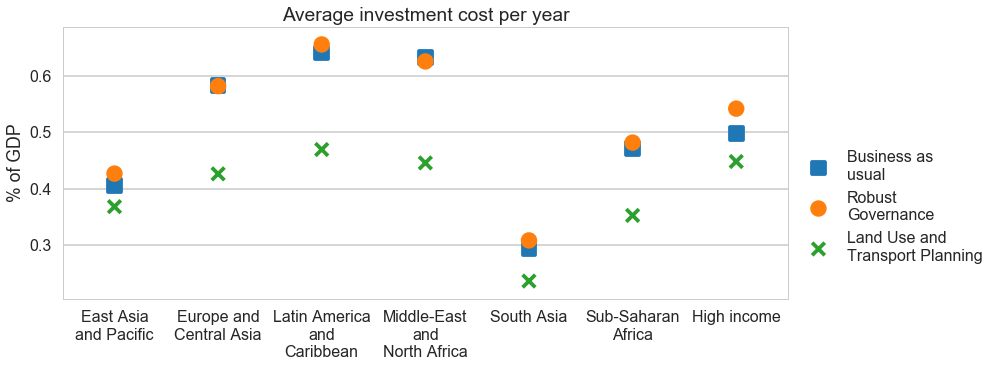

In [947]:
toplot = all_v_r_s.reset_index().set_index(["SC","wbregion","Year"])
toplot = toplot[["total_inv_over_gdp_country"]].mean(level=["SC","wbregion"]).reset_index()
toplot["SC"] = toplot.SC.replace({"BAU":"0BAU","LUT":"2LUT","ROG":"1ROG"})
toplot = toplot.set_index("SC").sort_index(level="SC")
toplot = toplot.reset_index()

toplot['wbregion'] = toplot.wbregion.replace({"EAP":"East Asia\nand Pacific",
                                             "ECA":"Europe and\nCentral Asia",
                                             "LAC":"Latin America\nand\nCaribbean",
                                             "MNA":"Middle-East\nand\nNorth Africa",
                                             "SAS":"South Asia",
                                             "SSA":"Sub-Saharan\nAfrica",
                                             "YHI":"High income"})
toplot["total_inv_over_gdp_country"] = 100*toplot.total_inv_over_gdp_country

toplot["SC"] = toplot.SC.replace({"0BAU":"Business as\nusual","2LUT":"Land Use and\nTransport Planning","1ROG":"Robust\nGovernance"})

plt.figure(figsize=(13,5))

ax1=sns.pointplot(x="wbregion", y="total_inv_over_gdp_country",hue="SC", data=toplot, join=False, markers=["s","o","x"])
plt.title("Average investment cost per year")
plt.ylabel("% of GDP")
#plt.ylim([0,0.035])
plt.xlabel("")
plt.legend(title="",bbox_to_anchor=(1., 0.6))

plt.savefig("ITF_total_inv_per_region_gdp_share.png",ddpi=300,bbox_inches="tight")
plt.savefig("ITF_total_inv_per_region_gdp_share.pdf")

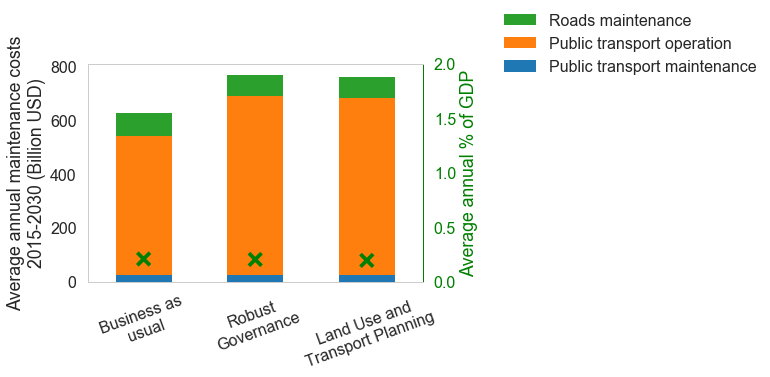

In [52]:
to_plot = all_v_s_dev.reset_index().set_index(["SC","Year"])[["pt_maintenance","pt_operation","roads_maintenance_disc"]].sum(level="SC")
to_plot = to_plot.reset_index()

to_plot2 = all_v_s_dev.reset_index().set_index(["SC","Year"])[["maintenance_over_gdp_country"]].mean(level="SC")
to_plot2 = to_plot2.reset_index()

to_plot["SC"] = to_plot.SC.replace({"BAU":"0BAU","LUT":"2LUT","ROG":"1ROG"})
to_plot = to_plot.set_index("SC").sort_index(level="SC")
to_plot = to_plot.reset_index()

to_plot2["SC"] = to_plot2.SC.replace({"BAU":"0BAU","LUT":"2LUT","ROG":"1ROG"})
to_plot2 = to_plot2.set_index("SC").sort_index(level="SC")
to_plot2 = to_plot2.reset_index()

to_plot["SC"] = to_plot.SC.replace({"0BAU":"Business as\nusual","2LUT":"Land Use and\nTransport Planning","1ROG":"Robust\nGovernance"})
to_plot2["SC"] = to_plot2.SC.replace({"0BAU":"Business as\nusual","2LUT":"Land Use and\nTransport Planning","1ROG":"Robust\nGovernance"})

to_plot["pt_maintenance"] = 1/15*to_plot.pt_maintenance
to_plot["roads_maintenance_disc"] = 1/15*to_plot.roads_maintenance_disc
to_plot["pt_operation"] = 1/15*to_plot.pt_operation

fig, ax1 = plt.subplots()
#fig.set_size_inches(15, 5)

to_plot.set_index("SC")[["pt_maintenance","pt_operation","roads_maintenance_disc"]].rename(columns={"pt_maintenance":"Public transport maintenance",\
                                                                                                    "roads_maintenance_disc":"Roads maintenance",\
                                                                                                   "pt_operation":"Public transport operation"}).plot(kind="bar",stacked=True,ax=ax1)
plt.xticks(rotation=20)
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],bbox_to_anchor=(1.2, 1.3))
plt.xlabel("")
plt.ylabel("Average annual maintenance costs\n2015-2030 (Billion USD)")
#ax1.set_ylim([0,3000])
ax1.grid(b=None)

to_plot2['maintenance_over_gdp_country'] = 100*to_plot2.maintenance_over_gdp_country

ax11 = ax1.twinx()
sns.pointplot(x="SC",y="maintenance_over_gdp_country",join=False,ax=ax11,data=to_plot2,color="green",markers='x')
ax11.grid(b=None)
ax11.set_ylabel("Average annual % of GDP")
ax11.set_ylim([0,2])
ax11.spines['right'].set_color('green')
ax11.tick_params(axis='y', colors='green')
ax11.yaxis.label.set_color('green')

#plt.savefig("ITF_total_inv_maintenance.png",ddpi=300,bbox_inches="tight")
#plt.savefig("ITF_total_inv_maintenance.pdf")

In [56]:
100*all_v_s_dev.operations_over_gdp_country.mean(level="SC")

SC
BAU    0.992870
LUT    1.268546
ROG    1.280880
Name: operations_over_gdp_country, dtype: float64

### Chiffre: All maintenance and operation costs

In [57]:
to_plot[["pt_maintenance","roads_maintenance_disc","pt_operation"]].sum(axis=1)

0    627.862963
1    772.358842
2    761.785150
dtype: float64

In [58]:
to_plot[["pt_maintenance","roads_maintenance_disc"]].sum(axis=1)

0    108.876971
1    106.429296
2    102.105100
dtype: float64

In [59]:
to_plot[["pt_operation"]].sum(axis=1)

0    518.985992
1    665.929546
2    659.680049
dtype: float64

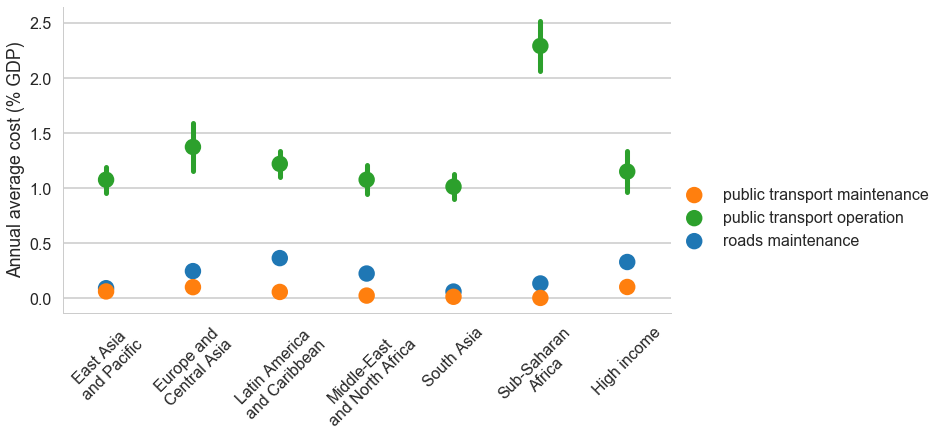

In [66]:
toplot = all_v_r_s.reset_index().set_index(["SC","wbregion","Year"])
toplot = toplot[["total_road_maint_over_gdp_country","total_pt_maint_over_gdp_country","total_pt_ope_over_gdp_country"]].mean(level=["SC","wbregion"])
toplot.columns.name = "capital_type"
toplot = toplot.stack()
toplot.name = 'value'
toplot = toplot.reset_index()

toplot = toplot.set_index("wbregion").sort_index(level="wbregion")
toplot = toplot.reset_index()

toplot['wbregion'] = toplot.wbregion.replace({"EAP":"East Asia\nand Pacific",
                                             "ECA":"Europe and\nCentral Asia",
                                             "LAC":"Latin America\nand Caribbean",
                                             "MNA":"Middle-East\nand North Africa",
                                             "SAS":"South Asia",
                                             "SSA":"Sub-Saharan\nAfrica",
                                             "YHI":"High income"})

toplot["capital_type"] = toplot.capital_type.replace({"total_road_maint_over_gdp_country":"roads maintenance",\
                                                          "total_pt_maint_over_gdp_country":"public transport maintenance",\
                                                     "total_pt_ope_over_gdp_country":"public transport operation"})

toplot['value']=100*toplot.value

#toplot["SC"] = toplot.SC.replace({"0BAU":"Business as\nusual","2LUT":"Land Use and\nTransport Planning","1ROG":"Robust\nGovernance"})

g = sns.factorplot(x='wbregion',y='value',hue='capital_type',data=toplot, kind="point",dodge=False, size=6, aspect=1.7,\
                  legend=False, join=False, ci='sd')

g.set_axis_labels("", "Annual average cost (% GDP)")
g.add_legend(title="")
plt.xticks(rotation=45)

plt.savefig("ITF_maint_per_region_av.png",ddpi=300,bbox_inches="tight")
plt.savefig("ITF_maint_per_region_av.pdf")

In [76]:
toplot.set_index(["wbregion","SC","capital_type"]).value.mean(level=["wbregion","capital_type"])

wbregion                       capital_type                
East Asia\nand Pacific         public transport maintenance    0.061914
                               public transport operation      1.076419
                               roads maintenance               0.091365
Europe and\nCentral Asia       public transport maintenance    0.100819
                               public transport operation      1.374259
                               roads maintenance               0.246428
High income                    public transport maintenance    0.102391
                               public transport operation      1.151028
                               roads maintenance               0.329210
Latin America\nand Caribbean   public transport maintenance    0.057310
                               public transport operation      1.220716
                               roads maintenance               0.364606
Middle-East\nand North Africa  public transport maintenance    0.024184
    

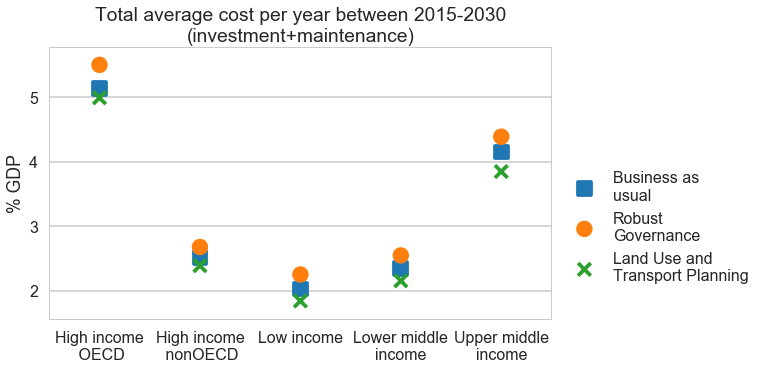

In [40]:
toplot = all_v_ir_s[["total_total_gdp_country"]].mean(level=["SC","wbincomename"]).reset_index()
toplot["wbincomename"]=toplot.wbincomename.str.replace(':','\n')
toplot["wbincomename"]=toplot.wbincomename.str.replace('middle ','middle\n')

toplot["SC"] = toplot.SC.replace({"BAU":"0BAU","LUT":"2LUT","ROG":"1ROG"})
toplot = toplot.set_index("SC").sort_index(level="SC")
toplot = toplot.reset_index()

toplot["SC"] = toplot.SC.replace({"0BAU":"Business as\nusual","2LUT":"Land Use and\nTransport Planning","1ROG":"Robust\nGovernance"})

toplot["total_total_gdp_country"] = 100*toplot.total_total_gdp_country

plt.figure(figsize=(9,5))

ax1=sns.pointplot(x="wbincomename", y="total_total_gdp_country",hue="SC", data=toplot, join=False, markers=["s","o","x"])
plt.title("Total average cost per year between 2015-2030\n(investment+maintenance)")
plt.ylabel("% GDP")
plt.xlabel("")
plt.legend(title="",bbox_to_anchor=(1.005, 0.6))

plt.savefig("ITF_total_per_income_region.png",ddpi=300,bbox_inches="tight")
plt.savefig("ITF_total_per_income_region.pdf")

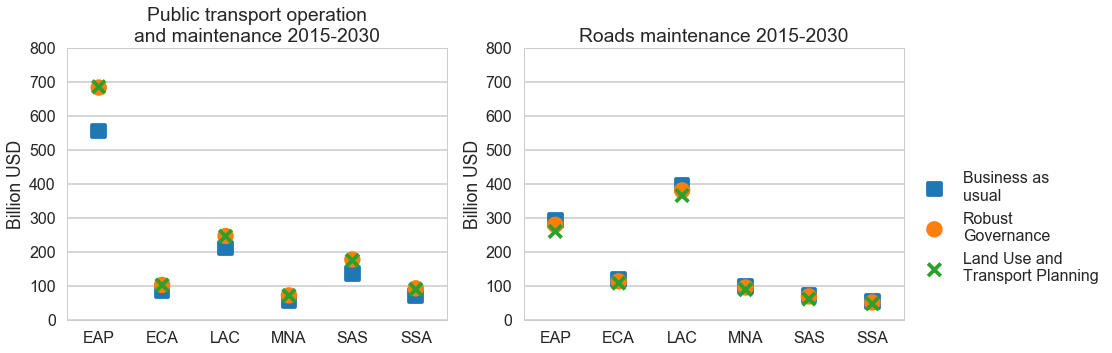

In [60]:
toplot = all_v_r_s.reset_index().loc[all_v_r_s.reset_index().wbregion!="YHI",:].set_index(["SC","wbregion","Year"])
toplot = toplot[["public_transport_investments_disc","road_investments_disc","pt_maintenance","roads_maintenance_disc"]].sum(level=["SC","wbregion"]).reset_index()
toplot["SC"] = toplot.SC.replace({"BAU":"0BAU","LUT":"2LUT","ROG":"1ROG"})
toplot = toplot.set_index("SC").sort_index(level="SC")
toplot = toplot.reset_index()



toplot["SC"] = toplot.SC.replace({"0BAU":"Business as\nusual","2LUT":"Land Use and\nTransport Planning","1ROG":"Robust\nGovernance"})

plt.figure(figsize=(15,5))

plt.subplot(121)
ax1=sns.pointplot(x="wbregion", y="pt_maintenance",hue="SC", data=toplot, join=False, markers=["s","o","x"])
plt.title("Public transport operation\nand maintenance 2015-2030")
plt.ylabel("Billion USD")
plt.xlabel("")
plt.ylim([0,800])
ax1.legend_.remove()

plt.subplot(122)
ax2=sns.pointplot(x="wbregion", y="roads_maintenance_disc",hue="SC", data=toplot, join=False, markers=["s","o","x"])
plt.title("Roads maintenance 2015-2030")
plt.ylabel("Billion USD")
plt.xlabel("")
plt.ylim([0,800])
plt.legend(title="",bbox_to_anchor=(1., 0.6))

plt.savefig("ITF_maint_per_region.png",ddpi=300,bbox_inches="tight")
plt.savefig("ITF_maint_per_region.pdf")

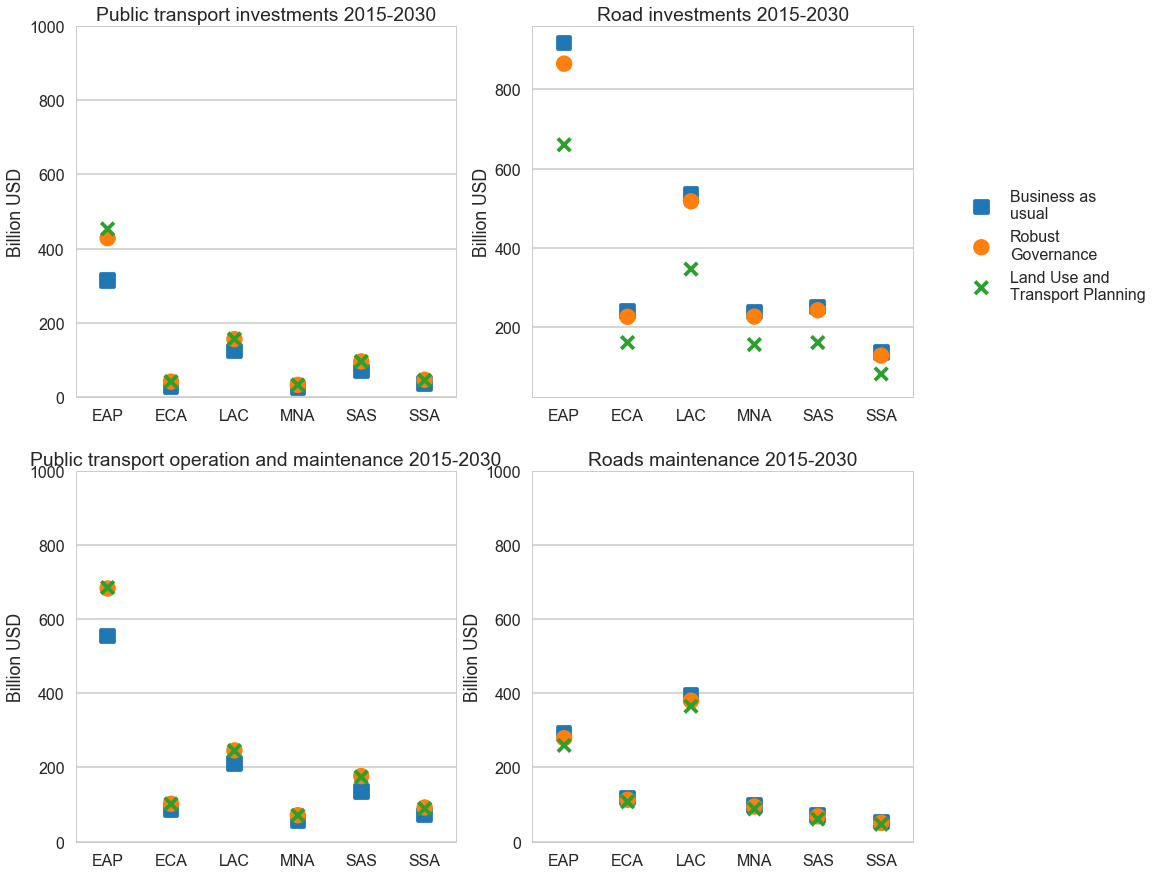

In [590]:
toplot = all_v_r_s.reset_index().loc[all_v_r_s.reset_index().wbregion!="YHI",:].set_index(["SC","wbregion","Year"])
toplot = toplot[["public_transport_investments_disc","road_investments_disc","pt_maintenance","roads_maintenance_disc"]].sum(level=["SC","wbregion"]).reset_index()
toplot["SC"] = toplot.SC.replace({"BAU":"0BAU","LUT":"2LUT","ROG":"1ROG"})
toplot = toplot.set_index("SC").sort_index(level="SC")
toplot = toplot.reset_index()

toplot["SC"] = toplot.SC.replace({"0BAU":"Business as\nusual","2LUT":"Land Use and\nTransport Planning","1ROG":"Robust\nGovernance"})

plt.figure(figsize=(15,15))

plt.subplot(221)
ax1=sns.pointplot(x="wbregion", y="public_transport_investments_disc",hue="SC", data=toplot, join=False, markers=["s","o","x"])
plt.title("Public transport investments 2015-2030")
plt.ylabel("Billion USD")
plt.xlabel("")
plt.ylim([0,1000])
ax1.legend_.remove()

plt.subplot(222)
ax2=sns.pointplot(x="wbregion", y="road_investments_disc",hue="SC", data=toplot, join=False, markers=["s","o","x"])
plt.ylabel("Billion USD")
plt.title("Road investments 2015-2030")
plt.legend(title="",bbox_to_anchor=(1.1, 0.6))
plt.xlabel("")

plt.subplot(223)
ax1=sns.pointplot(x="wbregion", y="pt_maintenance",hue="SC", data=toplot, join=False, markers=["s","o","x"])
plt.title("Public transport operation and maintenance 2015-2030")
plt.ylabel("Billion USD")
plt.xlabel("")
plt.ylim([0,1000])
ax1.legend_.remove()

plt.subplot(224)
ax1=sns.pointplot(x="wbregion", y="roads_maintenance_disc",hue="SC", data=toplot, join=False, markers=["s","o","x"])
plt.title("Roads maintenance 2015-2030")
plt.ylabel("Billion USD")
plt.xlabel("")
plt.ylim([0,1000])
ax1.legend_.remove()

plt.savefig("ITF_per_cost_per_region.png",ddpi=300,bbox_inches="tight")
plt.savefig("ITF_per_cost_per_region.pdf")

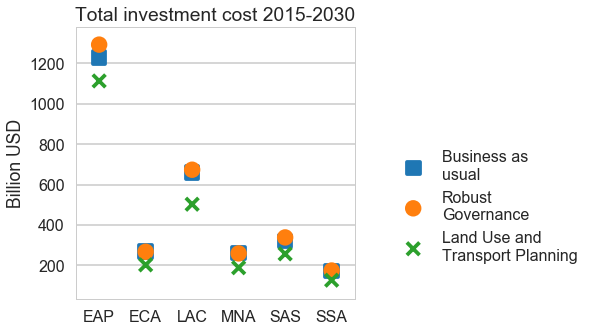

In [49]:
toplot = all_v_r_s.reset_index().loc[all_v_r_s.reset_index().wbregion!="YHI",:].set_index(["SC","wbregion","Year"])
toplot = toplot[["total_inv_disc"]].sum(level=["SC","wbregion"]).reset_index()
toplot["SC"] = toplot.SC.replace({"BAU":"0BAU","LUT":"2LUT","ROG":"1ROG"})
toplot = toplot.set_index("SC").sort_index(level="SC")
toplot = toplot.reset_index()

toplot["SC"] = toplot.SC.replace({"0BAU":"Business as\nusual","2LUT":"Land Use and\nTransport Planning","1ROG":"Robust\nGovernance"})

plt.figure(figsize=(5,5))

ax1=sns.pointplot(x="wbregion", y="total_inv_disc",hue="SC", data=toplot, join=False, markers=["s","o","x"])
plt.title("Total investment cost 2015-2030")
plt.ylabel("Billion USD")
#plt.ylim([0,0.035])
plt.xlabel("")
plt.legend(title="",bbox_to_anchor=(1.1, 0.6))

plt.savefig("ITF_total_inv_per_region.png",ddpi=300,bbox_inches="tight")
plt.savefig("ITF_total_inv_per_region.pdf")

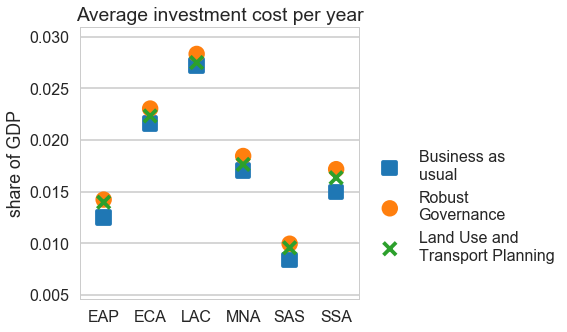

In [54]:
toplot = all_v_r_s.reset_index().set_index(["SC","wbregion","Year"])
toplot = toplot[["total_maint_over_gdp_country"]].mean(level=["SC","wbregion"]).reset_index()
toplot["SC"] = toplot.SC.replace({"BAU":"0BAU","LUT":"2LUT","ROG":"1ROG"})
toplot = toplot.set_index("SC").sort_index(level="SC")
toplot = toplot.reset_index()

toplot["SC"] = toplot.SC.replace({"0BAU":"Business as\nusual","2LUT":"Land Use and\nTransport Planning","1ROG":"Robust\nGovernance"})

plt.figure(figsize=(5,5))

ax1=sns.pointplot(x="wbregion", y="total_maint_over_gdp_country",hue="SC", data=toplot, join=False, markers=["s","o","x"])
plt.title("Average maintenance cost per year")
plt.ylabel("share of GDP")
#plt.ylim([0,0.035])
plt.xlabel("")
plt.legend(title="",bbox_to_anchor=(1., 0.6))

plt.savefig("ITF_total_maint_per_region_gdp_share.png",ddpi=300,bbox_inches="tight")
plt.savefig("ITF_total_maint_per_region_gdp_share.pdf")

In [50]:
toplot.set_index("SC")["total_inv_disc"].sum(level="SC")/toplot.set_index("SC")["total_inv_disc"].sum(level="SC")["Business as\nusual"]

SC
Business as\nusual                  1.000000
Land Use and\nTransport Planning    0.820727
Robust\nGovernance                  1.032397
Name: total_inv_disc, dtype: float64

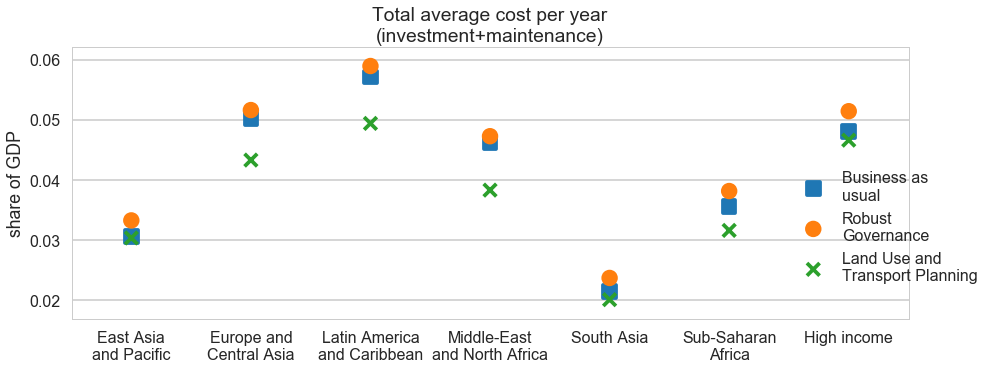

In [136]:
#toplot = all_v_r_s.reset_index().loc[all_v_r_s.reset_index().wbregion!="YHI",:].set_index(["SC","wbregion","Year"])

toplot = all_v_r_s.reset_index().set_index(["SC","wbregion","Year"])[["total_total_gdp_country"]].mean(level=["SC","wbregion"]).reset_index()
toplot["SC"] = toplot.SC.replace({"BAU":"0BAU","LUT":"2LUT","ROG":"1ROG"})
toplot = toplot.set_index("SC").sort_index(level="SC")
toplot = toplot.reset_index()

toplot['wbregion'] = toplot.wbregion.replace({"EAP":"East Asia\nand Pacific",
                                             "ECA":"Europe and\nCentral Asia",
                                             "LAC":"Latin America\nand Caribbean",
                                             "MNA":"Middle-East\nand North Africa",
                                             "SAS":"South Asia",
                                             "SSA":"Sub-Saharan\nAfrica",
                                             "YHI":"High income"})

toplot["SC"] = toplot.SC.replace({"0BAU":"Business as\nusual","2LUT":"Land Use and\nTransport Planning","1ROG":"Robust\nGovernance"})

plt.figure(figsize=(15,5))

ax1=sns.pointplot(x="wbregion", y="total_total_gdp_country",hue="SC", data=toplot, join=False, markers=["s","o","x"])
plt.title("Total average cost per year\n(investment+maintenance)")
plt.ylabel("share of GDP")
#plt.ylim([0,0.035])
plt.xlabel("")
plt.legend(title="",bbox_to_anchor=(1.1, 0.6))

plt.savefig("ITF_total_per_region.png",ddpi=300,bbox_inches="tight")
plt.savefig("ITF_total_per_region.pdf")

In [367]:
all_v_r_s.total_inv_over_gdp_country.unstack("Year").drop([2035,2040,2045,2050],axis=1).mean(axis=1).unstack("SC")

SC,BAU,LUT,ROG
wbregion,,,
EAP,0.018103,0.016385,0.019050
ECA,0.028662,0.020998,0.028601
LAC,0.029932,0.021937,0.030648
MNA,0.029178,0.020685,0.028845
SAS,0.013052,0.010530,0.013744
SSA,0.020625,0.015276,0.020995


In [598]:
all_v_s.total_inv_disc.sum(level="SC")/all_v_s.total_inv_disc.sum(level="SC")["BAU"]

SC
BAU    1.000000
LUT    0.820852
ROG    1.032659
Name: total_inv_disc, dtype: float64

In [368]:
all_v_s.total_inv_over_gdp_country.unstack("Year")

Year,2015,2020,2025,2030,2035,2040,2045,2050
SC,,,,,,,,
BAU,0.022634,0.022773,0.019512,0.017273,0.016107,0.014489,0.013265,0.012166
LUT,0.022752,0.022605,0.011011,0.010737,0.009954,0.009598,0.009096,0.008752
ROG,0.022752,0.022605,0.020612,0.019005,0.018780,0.017326,0.016393,0.015607


In [193]:
all_v_s[["public_transport_investments_disc","road_investments_disc"]].sum(level="SC").sum(axis=1)

SC
BAU    6118.501230
LUT    5352.631204
ROG    6461.623477
dtype: float64

In [529]:
aa = 10**(-9)*(all_v_s.reset_index().loc[all_v_s.reset_index().Year==2030,["carPKM","motorPKM","ptPKM","cyclePKM","walkPKM","SC"]].set_index("SC"))
aa["total"]=aa.sum(axis=1)

aa[["carPKM","motorPKM","ptPKM","cyclePKM","walkPKM"]].div(aa.total,axis=0)

,carPKM,motorPKM,ptPKM,cyclePKM,walkPKM
SC,,,,,
BAU,0.385857,0.172459,0.403211,0.023071,0.015402
LUT,0.231884,0.151723,0.583561,0.019754,0.013078
ROG,0.244741,0.153505,0.567014,0.020849,0.013892


In [531]:
aa.total/aa.loc["BAU","total"]

SC
BAU    1.000000
LUT    0.969637
ROG    1.033070
Name: total, dtype: float64

In [40]:
all_v_s["allpkm"] = all_v_s.carPKM+all_v_s.cyclePKM+all_v_s.walkPKM+all_v_s.motorPKM+all_v_s.ptPKM

In [343]:
all_v_s.allpkm.sum(level="SC")

SC
BAU    1.338194e+14
LUT    1.333646e+14
ROG    1.447235e+14
Name: allpkm, dtype: float64

In [107]:
all_c.loc[all_c.Density>100,["city_name","SC","Year","ISO3"]].city_name.unique()

array(['Kabul', 'Fangchenggang', 'Batam', 'Las Vegas', 'Port-au-Prince',
       'Lagos', 'Thrissur', 'Kochi (Cochin)', 'Lokoja', 'San Diego'], dtype=object)

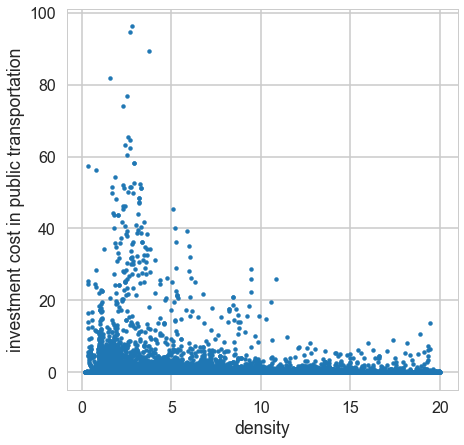

In [119]:
tempo = all_c.loc[(all_c.Density<20)&(all_c.infraPt>0)&(all_c.infraPt<100),:]

fig = plt.figure(figsize=(7,7))
plt.scatter(tempo.Density,tempo.infraPt,s=15)
plt.xlabel("density")
plt.ylabel("investment cost in public transportation")

In [117]:
all_c.GCAP.describe()

count     37368.000000
mean      22219.575265
std       23550.209842
min         219.107477
25%        7736.372272
50%       14460.462772
75%       31091.330940
max      689961.017594
Name: GCAP, dtype: float64

In [111]:
all_c.loc[all_c.infraPt>100,["city_name","infraPt","Year","ISO3","Density"]]

,city_name,infraPt,Year,ISO3,Density
11195,Heshan_Zhuhai_Jiangmen_Huizhou_Zhongshan_Fosha...,108.497658,2030,CHN,3.659531
11197,Heshan_Zhuhai_Jiangmen_Huizhou_Zhongshan_Fosha...,133.827902,2035,CHN,2.670070
11200,Heshan_Zhuhai_Jiangmen_Huizhou_Zhongshan_Fosha...,105.241567,2040,CHN,2.506611
11201,Heshan_Zhuhai_Jiangmen_Huizhou_Zhongshan_Fosha...,108.805669,2040,CHN,3.783192
11203,Heshan_Zhuhai_Jiangmen_Huizhou_Zhongshan_Fosha...,115.030044,2045,CHN,2.379559
11204,Heshan_Zhuhai_Jiangmen_Huizhou_Zhongshan_Fosha...,118.781241,2045,CHN,3.804588
11206,Heshan_Zhuhai_Jiangmen_Huizhou_Zhongshan_Fosha...,128.919289,2050,CHN,2.283419
11207,Heshan_Zhuhai_Jiangmen_Huizhou_Zhongshan_Fosha...,132.804071,2050,CHN,3.808516
14715,Utsunomiya_Tokyo,163.807454,2020,JPN,1.978836
14716,Utsunomiya_Tokyo,187.089364,2020,JPN,1.978836


In [134]:
all_c.wbregion.unique()

array(['YHI', 'EAP', 'ECA', 'MNA', 'SAS', 'SSA', 'LAC', nan], dtype=object)

In [50]:
all_c.sample(3)

,index,city_ID_x,SC,Year,ISO3,Income.group,POP,GCAP,carPKM,motorPKM,...,total_inv,GDP,total_inv_over_gdp,country_name,wbregion,wbregionname,wbincome,wbincomename,wblending,wbhipc
5283,5283,224,BAU,2020,CHN,Upper middle income,7588,6626.063067,1.655011e+10,1.049423e+10,...,6.953919,5.027857e+10,0.138308,China,EAP,East Asia & Pacific,UMI,Upper middle income,IBRD,NaN
6283,6283,265,ROG,2045,CHN,Upper middle income,619,19691.804875,9.915335e+08,4.422140e+08,...,0.091590,1.218923e+10,0.007514,China,EAP,East Asia & Pacific,UMI,Upper middle income,IBRD,NaN
18056,18056,750,LUT,2025,MEX,Upper middle income,781,12631.034221,1.290917e+09,8.887749e+07,...,0.169105,9.864838e+09,0.017142,Mexico,LAC,Latin America & Caribbean,UMI,Upper middle income,IBRD,NaN


In [55]:
all_c.columns

Index(['index', 'city_ID_x', 'SC', 'Year', 'ISO3', 'Income.group', 'POP',
       'GCAP', 'carPKM', 'motorPKM', 'ptPKM', 'walkPKM', 'cyclePKM', 'totTrip',
       'Density', 'city_name', 'city_ID_y', 'infraPt', 'capitalCostBus',
       'busVKM', 'ptVKM', 'busEmiss', 'lighRail_BRTLength',
       'undergroundRailLength', 'OM_infraPt', 'OM_vehiclePt', 'city_ID',
       'localroad_invest_billion', 'mainroad_invest_billion', 'main_road',
       'car_usage', 'car_capital_cost', 'carEmiss', 'local_rd',
       'road_OM_extra', 'road_OM_2015', 'CarVKM', 'total_inv', 'GDP',
       'total_inv_over_gdp', 'country_name', 'wbregion', 'wbregionname',
       'wbincome', 'wbincomename', 'wblending', 'wbhipc'],
      dtype='object')

In [104]:
temp = all_c.set_index(["Year","SC","city_ID"])["Density"].to_frame()
temp['Density'] = np.log(temp.Density)

In [ ]:
for i, txt in enumerate(n):
    ax.annotate(txt, (z[i],y[i]))

In [92]:
city_dict = dict(all_c.reset_index().set_index("city_name").city_ID.drop_duplicates())

In [124]:
all_c.loc[(all_c.POP>1000)&(all_c.Density<200)&(all_c.Density>100),"city_name"].unique()

array(['Kabul', 'Batam', 'Las Vegas', 'Port-au-Prince', 'Lagos',
       'Thrissur', 'Kochi (Cochin)', 'Lokoja', 'San Diego'], dtype=object)

In [172]:
all_c.loc[all_c.ISO3=="COD","city_name"].unique()

array(['Kisangani', 'Goma', 'Kikwit', 'Matadi', 'Kananga', 'Mbuji-Mayi',
       'Tshikapa', 'Kolwezi', 'Likasi', 'Lubumbashi', 'Uvira',
       'Brazzaville_Kinshasa', 'Bunia', 'Mbandaka', 'Bukavu'], dtype=object)

In [146]:
temp.loc[temp.city_ID==city_dict.get("Bhiwandi_Mumbai (Bombay)")]

Year,city_ID,level_1,SC,2015,2030
1251,1366,Density,BAU,15237.30859,11605.660993
1252,1366,Density,LUT,15237.30859,16537.822712
1253,1366,Density,ROG,15237.30859,11605.660993


In [141]:
temp.loc[temp.city_ID==city_dict.get("Karachi")]

Year,city_ID,level_1,SC,2015,2030
1152,1257,Density,BAU,19807.008761,17517.822436
1153,1257,Density,LUT,19807.008761,24769.766176
1154,1257,Density,ROG,19807.008761,17517.822436


In [142]:
temp.loc[temp.city_ID==city_dict.get("Lima")]

Year,city_ID,level_1,SC,2015,2030
825,889,Density,BAU,6024.987421,5159.931221
826,889,Density,LUT,6024.987421,6620.317978
827,889,Density,ROG,6024.987421,5159.931221


In [149]:
temp.loc[temp.city_ID==city_dict.get("Manila")]

Year,city_ID,level_1,SC,2015,2030
381,471,Density,BAU,9142.671114,7196.714077
382,471,Density,LUT,9142.671114,10114.689029
383,471,Density,ROG,9142.671114,7196.714077


In [177]:
temp.loc[temp.city_ID==city_dict.get("Accra")]

Year,city_ID,level_1,SC,2015,2030
18,1137,Density,BAU,2167.67726,1865.575341
19,1137,Density,LUT,2167.67726,2606.379949
20,1137,Density,ROG,2167.67726,1865.575341


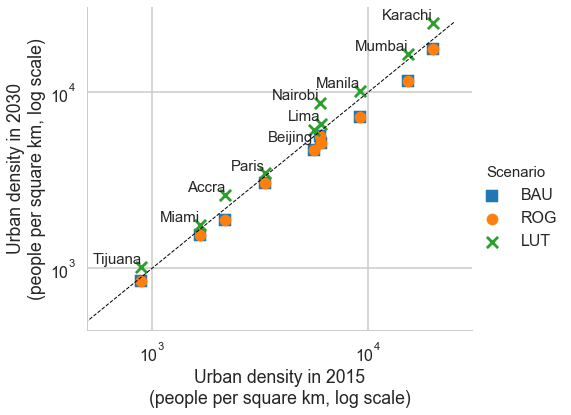

In [178]:
city_list = ["Paris","Miami","Nairobi","Beijing","Tijuana","Karachi","Lima","Manila","Bhiwandi_Mumbai (Bombay)","Accra"]

temp = all_c.loc[[x in city_list for x in all_c.city_name]].set_index(["Year","SC","city_ID"])["Density"].to_frame()
temp["Density"] = 1000*temp.Density
#temp['Density'] = np.log(temp.Density)

temp = temp.stack().unstack("SC").dropna().stack().unstack("Year")[[2015,2030]].dropna().reset_index()

#g = sns.factorplot(x=2015,y=2030,hue="SC",\
#              kind="scatter",data=temp, size=5, aspect=1.2,\
#                  legend=False)
g = sns.FacetGrid(temp, hue="SC", 
                   hue_order=["BAU", "ROG", "LUT"],
                   hue_kws=dict(marker=["s", "o",'x']),
                   size=6, aspect=1.2)
g = (g.map(plt.scatter, 2015, 2030)
      .add_legend(title="Scenario")
       )
g.set_axis_labels("Urban density in 2015\n(people per square km, log scale)","Urban density in 2030\n(people per square km, log scale)")

ax = plt.gca()


temp2 = temp.loc[temp.SC=="LUT"].reset_index()
for city in city_list:
    city_ID = city_dict.get(city)
    if city=="Bhiwandi_Mumbai (Bombay)":
        city="Mumbai"
    if (city=="Beijing"):
        ax.text(temp2.loc[temp2.city_ID==city_ID,2015].values[0],temp2.loc[temp2.city_ID==city_ID,2030].values[0],city,fontsize=15,verticalalignment='top',horizontalalignment='right')
    else:    
        ax.text(temp2.loc[temp2.city_ID==city_ID,2015].values[0],temp2.loc[temp2.city_ID==city_ID,2030].values[0],city,fontsize=15,verticalalignment='bottom',horizontalalignment='right')
    
ax.plot([0,25000],[0,25000],'k--',linewidth=1)

ax.set(xscale="log", yscale="log")

plt.savefig("ITF_density_2015_2030_log_cities.png",ddpi=300,bbox_inches="tight")
plt.savefig("ITF_density_2015_2030_log_cities.pdf")

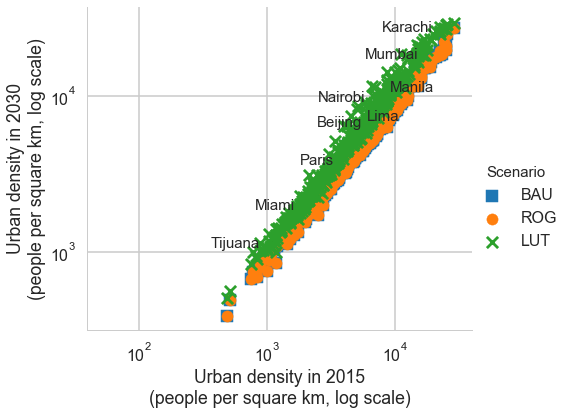

In [153]:
temp = all_c.loc[(all_c.POP>1000)&(all_c.Density<30)].set_index(["Year","SC","city_ID"])["Density"].to_frame()
temp["Density"] = 1000*temp.Density
#temp['Density'] = np.log(temp.Density)

temp = temp.stack().unstack("SC").dropna().stack().unstack("Year")[[2015,2030]].dropna().reset_index()

#g = sns.factorplot(x=2015,y=2030,hue="SC",\
#              kind="scatter",data=temp, size=5, aspect=1.2,\
#                  legend=False)
g = sns.FacetGrid(temp, hue="SC", 
                   hue_order=["BAU", "ROG", "LUT"],
                   hue_kws=dict(marker=["s", "o",'x']),
                   size=6, aspect=1.2)
g = (g.map(plt.scatter, 2015, 2030)
      .add_legend(title="Scenario")
       )
g.set_axis_labels("Urban density in 2015\n(people per square km, log scale)","Urban density in 2030\n(people per square km, log scale)")

ax = plt.gca()
ax.set(xscale="log", yscale="log")

temp2 = temp.loc[temp.SC=="LUT"].reset_index()
for city in ["Paris","Miami","Nairobi","Beijing","Tijuana","Karachi","Lima","Manila","Bhiwandi_Mumbai (Bombay)"]:
    city_ID = city_dict.get(city)
    if city=="Bhiwandi_Mumbai (Bombay)":
        city="Mumbai"
    if (city=="Lima")|(city=="Manila"):
        ax.text(temp2.loc[temp2.city_ID==city_ID,2015].values[0],temp2.loc[temp2.city_ID==city_ID,2030].values[0],city,fontsize=15,verticalalignment='bottom',horizontalalignment='left')
    else:    
        ax.text(temp2.loc[temp2.city_ID==city_ID,2015].values[0],temp2.loc[temp2.city_ID==city_ID,2030].values[0],city,fontsize=15,verticalalignment='bottom',horizontalalignment='right')
    

#plt.savefig("ITF_density_2015_2030_log.png",ddpi=300,bbox_inches="tight")
#plt.savefig("ITF_density_2015_2030_log.pdf")

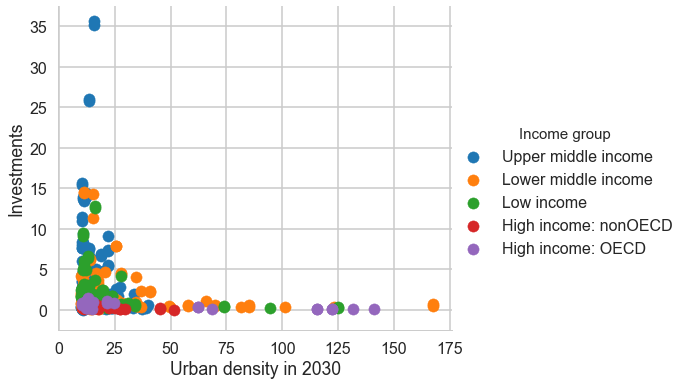

In [169]:
tempo = all_c.loc[(all_c.Density>10)&(all_c.Density<200)&(all_c.total_inv_over_gdp>0)&(all_c.Year==2030),:].copy()
tempo["total_inv_over_gdp"] = 100*tempo.total_inv_over_gdp

#fig = plt.figure(figsize=(6,6))
#plt.scatter(np.log(tempo.Density),np.log(tempo.total_inv_over_gdp),s=30,hue=tempo.wbincome)
#plt.xlabel("Urban density in 2030 (thousand people/km2)")
#plt.ylabel("Investment need in transport infrastructure\n(share of city GDP 2025-2030)")

#tempo['Density'] = np.log(tempo.Density)
#tempo['total_inv_over_gdp'] = np.log(tempo.total_inv_over_gdp)

g = sns.FacetGrid(tempo, hue="wbincomename",
                   size=6, aspect=1.2)
g = (g.map(plt.scatter, "Density", "total_inv_over_gdp")
      .add_legend(title="Income group")
       )
g.set_axis_labels("Urban density in 2030","Investments")


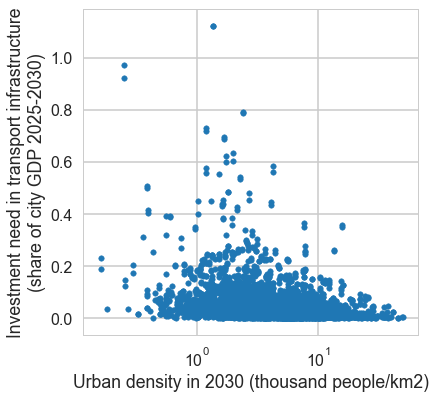

In [176]:
tempo = all_c.loc[(all_c.Density<50)&(all_c.total_inv_over_gdp>0)&(all_c.Year==2030),:]

fig = plt.figure(figsize=(6,6))
ax=plt.gca()
ax.scatter(tempo.Density,tempo.total_inv_over_gdp,s=30)
plt.xlabel("Urban density in 2030 (thousand people/km2)")
plt.ylabel("Investment need in transport infrastructure\n(share of city GDP 2025-2030)")
#ax.set_yscale("log")
ax.set_xscale("log")
#plt.savefig("ITF_density.png",ddpi=300,bbox_inches="tight")
#plt.savefig("ITF_density.pdf")

In [145]:
all_c.loc[(all_c.wbregion!="YHI")&(all_c.Density>10)&(all_c.total_inv_over_gdp>0.2)&(all_c.Year==2030),:]

,index,city_ID_x,SC,Year,ISO3,POP,GCAP,carPKM,motorPKM,ptPKM,...,total_inv,GDP,total_inv_over_gdp,country_name,wbregion,wbregionname,wbincome,wbincomename,wblending,wbhipc
537,537,23,BAU,2030,IRQ,1766,4813.789360,3.441763e+09,4.347006e+08,2.043767e+09,...,2.228343,8.501152e+09,0.262123,Iraq,MNA,Middle East & North Africa,UMI,Upper middle income,IBRD,NaN
538,538,23,ROG,2030,IRQ,1766,4813.789360,2.222752e+09,4.655921e+08,2.909454e+09,...,2.221761,8.501152e+09,0.261348,Iraq,MNA,Middle East & North Africa,UMI,Upper middle income,IBRD,NaN
705,705,30,BAU,2030,IRQ,1571,3569.890351,3.039051e+09,3.754715e+08,2.134035e+09,...,2.014473,5.608298e+09,0.359195,Iraq,MNA,Middle East & North Africa,UMI,Upper middle income,IBRD,NaN
706,706,30,ROG,2030,IRQ,1571,3569.890351,1.918697e+09,3.964362e+08,3.014062e+09,...,2.002127,5.608298e+09,0.356994,Iraq,MNA,Middle East & North Africa,UMI,Upper middle income,IBRD,NaN
